In [1]:
using PyPlot
using LinearAlgebra

using Random, Distributions



In [2]:
function genX(n,m)       #Generiert eine Zufallskonfiguration des "Kristalls"
    X = Array{Float64}(undef,n,m)
     for i in 1:n
        for j in 1:m 
            X[i,j] = rand([-1,1])
            end
        end
    return X
    end

genX (generic function with 1 method)

In [3]:
#Randbedingungen des Isining models
function getNext(i,j,n,m) #Nicht zyklisch 
    
    O = [i-1,j]
    R = [i,j+1]
    U = [i+1,j]
    L = [i,j-1]
    
    if i==1          #Falls auf rand zugegriffen wird einfach momentane position ausgeben, incluster ist dann schon 1 und if-abfrage wirkt nicht
        O = [i,j]
    end
    if  i==n
        U = [i,j]
    end
    if j==m
        R = [i,j]
    end
    if j==1
        L = [i,j]
    end
    
    return O,R,U,L #Oben rechts Unten Links
end

getNext (generic function with 1 method)

In [4]:
#Wolff or Single-Cluster Algorithm
function WolfStep(X,T,J)
    
    
    n=length(X[:,1]) # n x m matrix (n zeilen)
    m=length(X[1,:])
    
    incluster = zeros(n,m) #Führt buch, ob Spin im Cluster ist. (Statisch,besser als den array "cluster" immer durchsuchen zu müssen)
    
    cluster = []
    stack = []
    prob = 1 - exp(-2*(1/T)*J) #wahrscheinlickeit ,dass spin ins Cluster kommt

    ii=rand(1:n)   #Zufälligen startpunkt wählen
    jj=rand(1:m)
    push!(cluster,[ii,jj]) 
    push!(stack, [ii,jj])
    incluster[ii,jj] = 1
    
    
    while length(stack) > 0      #Alle mögliche punkte abarbeiten, evtl. zum Stack/cluster hinzufügen
        
        i=stack[end][1]
        j=stack[end][2]
        pop!(stack)
        
        O,R,U,L = getNext(i,j,n,m) #Nachbarindexe herausfinden
        
        #jedernachbar vom aktuellen spin im Stack, der nicht schon im cluster ist und gleiche Ausrichtung hat, wird einmal vorgeschlagen
        
        if  incluster[O[1],O[2]]==0 && X[O[1],O[2]]*X[i,j]>0 && rand()<prob
            push!(cluster, [O[1],O[2]])
            push!(stack, [O[1],O[2]])
            incluster[O[1],O[2]]=1 #Merke, dass spin im Cluster ist
        end
        
        if  incluster[R[1],R[2]]==0 && X[R[1],R[2]]*X[i,j]>0 && rand()<prob
            push!(cluster,[R[1],R[2]])
            push!(stack, [R[1],R[2]])
            incluster[R[1],R[2]]=1 #Merke, dass spin im Cluster ist
        end
        
        if incluster[U[1],U[2]]==0 && X[U[1],U[2]]*X[i,j]>0 && rand()<prob
            push!(cluster, [U[1],U[2]])            
            push!(stack, [U[1],U[2]])
            incluster[U[1],U[2]]=1 #Merke, dass spin im Cluster ist
        end
        
        if incluster[L[1],L[2]]==0 && X[L[1],L[2]]*X[i,j]>0 && rand()<prob
            push!(cluster, [L[1],L[2]])
            push!(stack, [L[1],L[2]])
            incluster[L[1],L[2]]=1 #Merke, dass spin im Cluster ist
        end
      
       

    end
    
    #Cluster-Spinflip
    for pos in cluster
        X[pos[1],pos[2]] = -1*X[pos[1],pos[2]]
    end
    
    Clustersize = (sum(incluster)) #Um für höhere T mehr varianz in den zuständen zu haben (siehe Wolfkette)
    
    return X,Clustersize
    
end   

function WolfKette(N,n,m,T,J=1) #Array mit jeweils N Matrizen bzw konfigurationen als Einträge
    
    WolfKette = []
    X=genX(n,m)
    
    #Burn-in steps, weil startkonfig zufällig ist (siehe Einschub unten)
    if T<=2 
    for i in 1:400
        X = WolfStep(X,T,J)[1]
    end
    end
    
    if 2<T<2.5        #Um die Kritische Temperatur herum braucht man mehr Burningsteps
    for i in 1:900 #worstcase
        X = WolfStep(X,T,J)[1]
    end
    end 
    
     if T>=2.5 
    for i in 1:750 #um trotzdem noch gewisse präzision für M->0 zu haben
        X = WolfStep(X,T,J)[1]
    end
    end
    
    
    
    #Speichere Konfigurationen die nach der gegebenen Temperatur verteilt sind
    for i in 1:N
        push!(WolfKette,copy(X)) 
        Clustersize_total = 0
        
        #Burn-in2 für mehr konfigurationsvariation bei hohen T
        #Nächste konfiguration erst abspeichern, wenn die summierten größen der gebildeten cluster > n*m ist
        
           while Clustersize_total < n*m
            
            X, Clustersize_step = WolfStep(X,T,J)
            Clustersize_total += Clustersize_step
            
        end
        
    end
    
    return WolfKette
end

WolfKette (generic function with 2 methods)

**Generierte Daten Abspeichern**

In [5]:
using JLD2

In [50]:
function SaveWolfKetten(Länge,n,m,T_saverange)
    
    #=
    Generieren des Objektes, das wir abspeichern Wollen:
    In unserem Fall soll es ein Array sein mit [Temperatur {Float64},dazugehörige Wolfkette Vector{Matrix{Float64}}]
    =#
    
    XT = [WolfKette(Länge,n,m,T) for T in T_saverange]
    
    Datei = [T_saverange,XT]
    
    #Speichern
    save_object("W_Ketten T_Anzahl=$(length(T_saverange)) Länge=$Länge n_m=$(n*m) T1_T2=$(T_saverange[1])_$(T_saverange[end]).jdl2", Datei)
    
end

SaveWolfKetten (generic function with 1 method)

In [1]:
#Abspeichern

T_saverange = range(0.01,5, length=20)
# SaveWolfKetten(10000,10,10,T_saverange)

0.01:0.26263157894736844:5.0

**Einschub:** Wie viele Burningsteps?

In [ ]:
#Magnetisierung (Absolutwert)

function M(X) 
    n=length(X[:,1]) # n x m matrix (n zeilen)
    m=length(X[1,:])
    return abs((1/(n*m))*sum(X))
end

function M_mitt(Konfigs) #Mittelwert der Manetisierung mit Importance sampling ("Schnitt der Magnetsirung von den wahrscheinlilchsten zuständen")
    return abs((1/(length(Konfigs)))*sum([M(X) for X in Konfigs])) #Konfigs ein Array mit Mikrozusänden, jenachdem wie kreiert Wolf oder Markovkette.
end

In [5]:
#Inizialisierung Der Parameter

Burning_Dimension_n = 100  #Dimensionen des Zustandes
Burning_Dimension_m = 100
Burning_N = 1500 #Also Burning_N +1 Zustände
Burning_T = 2
Trajektorien_N = 30


#Erstellen der Trajektorien

Trajektorien = []  #Enthält den Verlauf von Trajektorien_N vielen Startwerten

for n in 1:Trajektorien_N
    
    #Für einen Startwert X, wird Jeder weitere zustand nach einem step in Zustände gespeichert
    Zustände = []
    Burning_X = genX(Burning_Dimension_n,Burning_Dimension_m)
    push!(Zustände,copy(Burning_X))
    
    #Burningsteps
    for i in 1:Burning_N
    
    Burning_X = WolfStep(Burning_X,Burning_T,1)[1] 
    push!(Zustände,copy(Burning_X))
        
    end
    push!(Trajektorien,copy(Zustände))
    
end

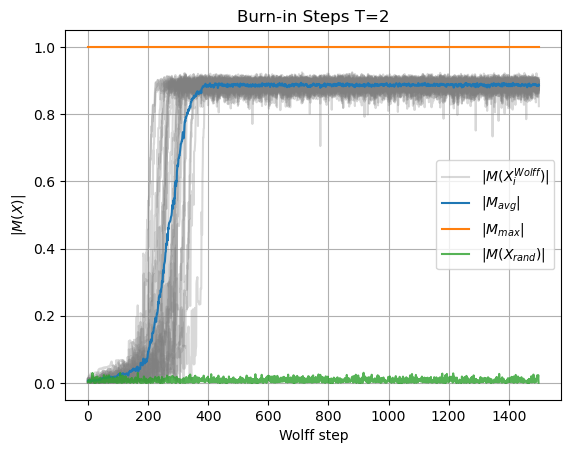

In [7]:
#Berechnen
M_avg = zeros(Burning_N+1)

#Trajektorien
for n in 1:Trajektorien_N
    
 if n==1
   plot([M(X) for X in Trajektorien[n]], color="grey",label=L"|M(X_i^{Wolff})|",alpha=0.3)
    elseif n>1
   plot([M(X) for X in Trajektorien[n]], color="grey", alpha=0.3)
end
    
    #Durchschnitt berechenen
    M_avg = M_avg + (1/Trajektorien_N).*[M(X) for X in Trajektorien[n]]
end

#Plotten

#Durchschnitt Plotten
plot(M_avg, label=L"|M_{avg}|")

#Orientierungswerte Plotten
RandomX =[]
for i in 1:Burning_N
    push!(RandomX,genX(Burning_Dimension_n,Burning_Dimension_m))
end
plot([0,Burning_N],[1,1], label=L"|M_{max}|")
plot([M(X) for X in RandomX], label=L"|M(X_{rand})|", alpha=0.8)


#kosmetik
title("Burn-in Steps T=$(Burning_T)")
ylabel(L"|M(X)|")
xlabel("Wolff step")
legend()
grid()

#save plot
plt.savefig("IMG/Burning T=2 100x100",dpi=400)

**Einschub Ende**

**Magnetisierung**

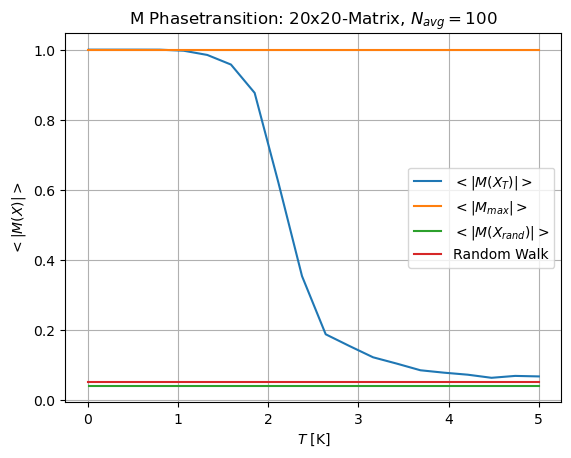

In [75]:
#Plotten der Mittleren Magnetisierung gegen die Temperatur
Mag_N_avg = 100
Mag_n = 20
Mag_m = Mag_n
T_range = range(0.01,5, length=20)

#Berechnung der Magnetisierung
Mag = [M_mitt(WolfKette(Mag_N_avg,Mag_n,Mag_m,T)) for T in T_range]
plot(T_range,Mag, label=L"<|M(X_T)|>")

#Orientierungswerte
plot([0,5],[1,1], label=L"<|M_{max}|>")  # Maximum

RandomX2 =[]                            # Mittelwert M von Mag_N_avg zufälligen Konfigurationen
for i in 1:Mag_N_avg
    push!(RandomX2,genX(Mag_n,Mag_m))
end
M_mitt_rand = abs((1/Mag_N_avg)*sum([M(X) for X in RandomX2]))
plot(T_range,[M_mitt_rand for T in T_range], label=L"<|M(X_{rand})|>")

plot([0,5],[Mag_n/Mag_n^2,Mag_n/Mag_n^2], label="Random Walk")
    
#kosmetik
title(L"M Phasetransition: %$(Mag_n)x%$(Mag_m)-Matrix, $N_{avg}=%$(Mag_N_avg)$")
ylabel(L"<|M(X)|>")
xlabel(L"$T$ [K]")
legend()
grid()

#save plot
plt.savefig("IMG/M Phasetransition",dpi=400)

**Algotithmus testen**

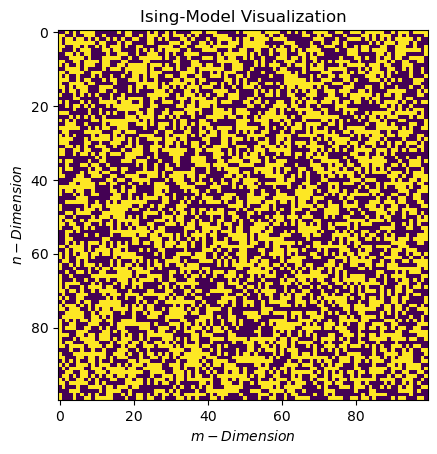

In [55]:
#Visualisierung
A = genX(100, 100)
imshow(A)
title("Ising-Model Visualization") 
xlabel(L"m-Dimension") 
ylabel(L"n-Dimension")

#save plot
plt.savefig("IMG/Ising_Model.png", dpi=400)

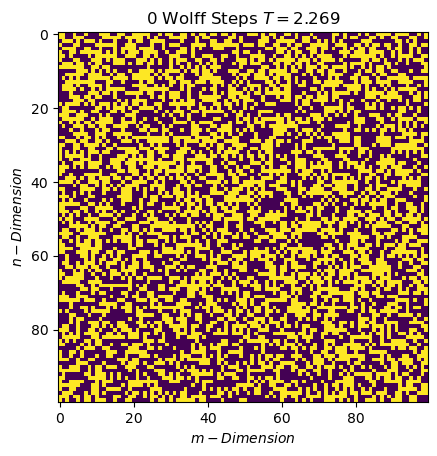

In [13]:
#Testen
A = genX(100, 100)
imshow(A)
title(L"0 Wolff Steps $T=2.269$") 
xlabel(L"m-Dimension") 
ylabel(L"n-Dimension")

#save plot
plt.savefig("IMG/0 steps T=2.25.png", dpi=400)

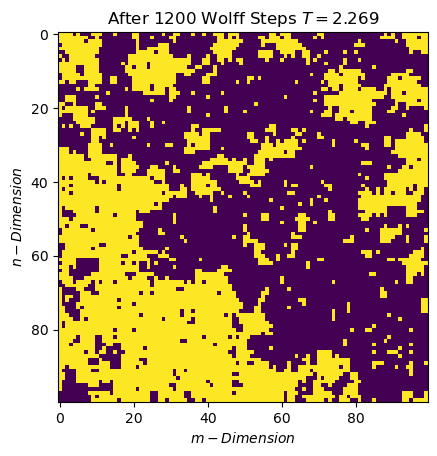

In [16]:
for i in 1:400
    A = WolfStep(A, 2.269, 1)[1]
end
imshow(A)
title(L"After 1200 Wolff Steps $T=2.269$") 
xlabel(L"m-Dimension") 
ylabel(L"n-Dimension")

#save plot
plt.savefig("IMG/1200 steps T=2.25.png", dpi=400)